## In-depth energy module behaviour (Procedural)

In this notebook, we set up a graph with a single edge to demonstrate some basic functionality of the Energy module by directly using procedural functions and simple data structures.

#### 0. Import libraries

In [1]:
# package(s) used for creating and geo-locating the graph
import networkx as nx
import pyproj
from pyproj import Geod
import shapely.geometry
from shapely.geometry import Point
import pathlib

# package(s) related to the simulation
import datetime
import opentnsim
from opentnsim.energy import algorithms, calculations

# package(s) needed for inspecting the output
import numpy as np
import pandas as pd

# package(s) needed for plotting
import matplotlib.pyplot as plt

print(f"This notebook is executed with OpenTNSim version {opentnsim.__version__}")

This notebook is executed with OpenTNSim version 1.3.7


#### 1. Define helper functions

We define a set of functions that encapsulate the energy calculation logic. Instead of a `Vessel` class, we use a dictionary (`vessel_data`) to store and pass the vessel's state and properties between these functions.

In [2]:
def create_vessel_data(**kwargs):
    """Creates a dictionary to hold all vessel properties and states."""
    vessel_data = {
        # TODO: Check why we need all these properties.  Some seem to be unrelated to vessels (e.g. g, rho)
        'nu': 1 * 10 ** (-6),
        'rho': 1000,
        'g': 9.81,
        'x': 2,
        'D_s': 1.4,
        'eta_o': 0.4,
        'eta_r': 1.00,
        'eta_t': 0.98,
        'eta_g': 0.96,
        'c_stern': 0,
        'C_BB': 0.2,
        'C_B': 0.85,
        'one_k2': 2.5,
        'current_year': 2024,
        'L': 100,
        'B': 20,
        'T': 7,
        'bulbous_bow': True,
        'P_installed': 5000,
        'P_hotel_perc': 0.05,
        'karpov_correction': True,
        'L_w': 3,
    }
    vessel_data.update(kwargs)
    
    vessel_data['P_hotel'] = vessel_data['P_hotel_perc'] * vessel_data['P_installed']
        
    age = calculations.sample_engine_age(vessel_data['L_w'])
    vessel_data['C_year'] = vessel_data['current_year'] - age
        
    props = calculations.calculate_properties(
        C_B=vessel_data['C_B'], L=vessel_data['L'], B=vessel_data['B'], T=vessel_data['T'],
        bulbous_bow=vessel_data['bulbous_bow'], C_BB=vessel_data['C_BB']
    )
    
    vessel_data.update(props._asdict())
    return vessel_data


In [11]:
pd.DataFrame([pd.Series(create_vessel_data())]).T

0
nu                    0.000001
rho                       1000
g                         9.81
x                            2
D_s                        1.4
eta_o                      0.4
eta_r                      1.0
eta_t                     0.98
eta_g                     0.96
c_stern                      0
C_BB                       0.2
C_B                       0.85
one_k2                     2.5
current_year              2024
L                          100
B                           20
T                            7
bulbous_bow               True
P_installed               5000
P_hotel_perc              0.05
karpov_correction         True
L_w                          3
P_hotel                  250.0
C_year                    2000
C_M                   0.996013
C_WP                       0.9
C_P                   0.853403
delta                  11900.0
lcb                   3.056017
L_R                  34.472673
A_T                       14.0
A_BT                  27.88835
S                  3019.327417
S_APP               150.966371
S_B                       2000
T_F                          7
h_B                        1.4

In [ ]:

def calculate_total_resistance(vessel_data, v, h_0):
    """Calculates all resistance components and updates the vessel dictionary."""
        
    res_fric = calculations.calculate_frictional_resistance(
        v=v, h_0=h_0, L=vessel_data['L'], nu=vessel_data['nu'], T=vessel_data['T'], 
        S=vessel_data['S'], S_B=vessel_data['S_B'], rho=vessel_data['rho'])
    fric_names = ['R_f', 'C_f', 'R_e', 'Cf_deep', 'Cf_shallow', 'Cf_0', 'Cf_Katsui', 'V_B', 'D', 'a']
    vessel_data.update(dict(zip(fric_names, res_fric)))

    res_viscous = calculations.calculate_viscous_resistance(
        c_stern=vessel_data['c_stern'], B=vessel_data['B'], L=vessel_data['L'], T=vessel_data['T'],
        L_R=vessel_data['L_R'], C_P=vessel_data['C_P'], R_f=vessel_data['R_f'], delta=vessel_data['delta'])
    vessel_data.update({'c_14': res_viscous[0], 'one_k1': res_viscous[1], 'R_f_one_k1': res_viscous[2]})
    
    vessel_data['R_APP'] = calculations.calculate_appendage_resistance(
        v=v, rho=vessel_data['rho'], S_APP=vessel_data['S_APP'], 
        one_k2=vessel_data['one_k2'], C_f=vessel_data['C_f'])

    res_karpov = calculations.karpov(v=v, h_0=h_0, g=vessel_data['g'], T=vessel_data['T'])
    vessel_data.update({'F_rh': res_karpov[0], 'V_2': res_karpov[1], 'alpha_xx': res_karpov[2]})

    v_wave_res = vessel_data['V_2'] if vessel_data['karpov_correction'] else v
    
    res_wave = calculations.calculate_wave_resistance(
        V_2=v_wave_res, h_0=h_0, g=vessel_data['g'], T=vessel_data['T'], L=vessel_data['L'], B=vessel_data['B'],
        C_P=vessel_data['C_P'], C_WP=vessel_data['C_WP'], lcb=vessel_data['lcb'], L_R=vessel_data['L_R'],
        A_T=vessel_data['A_T'], C_M=vessel_data['C_M'], delta=vessel_data['delta'], rho=vessel_data['rho'])
    wave_names = ['F_rL', 'i_E', 'c_1', 'c_2', 'c_5', 'c_7', 'c_15', 'c_16', 'lmbda', 'm_1', 'm_2', 'R_W']
    vessel_data.update(dict(zip(wave_names, res_wave)))

    res_res = calculations.calculate_residual_resistance(
        V_2=v_wave_res, g=vessel_data['g'], A_T=vessel_data['A_T'], B=vessel_data['B'], C_WP=vessel_data['C_WP'],
        rho=vessel_data['rho'], T=vessel_data['T'], L=vessel_data['L'], C_B=vessel_data['C_B'], S=vessel_data['S'],
        T_F=vessel_data['T_F'], h_B=vessel_data['h_B'], A_BT=vessel_data['A_BT'], bulbous_bow=vessel_data['bulbous_bow'])
    res_names = ['F_nT', 'c_6', 'R_TR', 'c_4', 'c_2_res', 'C_A', 'R_A', 'F_ni', 'P_B', 'R_B', 'R_res']
    vessel_data.update(dict(zip(res_names, res_res)))

    vessel_data['R_tot'] = (vessel_data['R_f'] * vessel_data['one_k1'] + vessel_data['R_APP'] + 
                             vessel_data['R_W'] + vessel_data['R_TR'] + vessel_data['R_A'] + vessel_data['R_B'])
    
def calculate_total_power_required(vessel_data, v):
    """Calculates all power components and updates the vessel dictionary."""
    power_vals = calculations.calculate_total_power_required(
        v=v, h_0=vessel_data['h_0'], R_tot=vessel_data['R_tot'], F_rL=vessel_data['F_rL'], x=vessel_data['x'],
        C_B=vessel_data['C_B'], delta=vessel_data['delta'], D_s=vessel_data['D_s'], eta_o=vessel_data['eta_o'],
        eta_r=vessel_data['eta_r'], eta_t=vessel_data['eta_t'], eta_g=vessel_data['eta_g'],
        P_hotel=vessel_data['P_hotel'], P_installed=vessel_data['P_installed'])
    power_names = ['P_e', 'dw', 'w', 't', 'eta_h', 'P_d', 'P_b', 'P_propulsion', 
                   'P_tot', 'P_given', 'P_partial']
    vessel_data.update(dict(zip(power_names, power_vals)))


#### 2. Create graph

Next, we create a network (a graph) along which the vessel can move. In this case, we create a single edge of exactly 100 km.

In [5]:
geod = Geod(ellps="WGS84")
lon0, lat0 = 0, 0
lon1, lat1, _ = geod.fwd(lon0, lat0, 90, 100000)

coords = {"0": (lon0, lat0), "1": (lon1, lat1)}
FG = nx.DiGraph()
for name, coord in coords.items():
    FG.add_node(name, geometry=Point(coord[0], coord[1]))
FG.add_edge("0", "1", weight=1, Info={'GeneralDepth': 10})
FG.add_edge("1", "0", weight=1, Info={'GeneralDepth': 10})

#### 3. Run Calculation

In [6]:
def run_calculation(vessel_params, v, distance, h_0):
    """Runs a single calculation for a given velocity and returns a results dictionary."""
    vessel_data = create_vessel_data(**vessel_params, v=v)
    vessel_data['h_0'] = h_0


    calculate_total_resistance(vessel_data, v, h_0)
    calculate_total_power_required(vessel_data, v)
    
    duration = distance / v
    total_energy = vessel_data['P_tot'] * duration / 3600  # kWh
    
    # Prepare results
    result = {
        'v': v,
        'P_tot': vessel_data['P_tot'],
        'total_energy': total_energy,
        'R_tot': vessel_data['R_tot'],
        'R_f_one_k1': vessel_data['R_f_one_k1'],
        'R_APP': vessel_data['R_APP'],
        'R_W': vessel_data['R_W'],
        'R_res': vessel_data['R_res']
    }
    return result

#### 4.1 Show the effects of vessel velocity on resistance, power and energy

We run the calculation for a range of velocities.

In [7]:
vessel_params = {
    'L': 135, 'B': 11.75, 'T': 2.75,
    'P_installed': 1750, 'L_w': 3, 'C_year': 1990,
    'karpov_correction': True, 'bulbous_bow': False,
    'P_hotel_perc': 0.05
}

velocity_range = np.arange(0.1, 6.0, 0.1)
results = []

distance_m = 100000
water_depth_m = 10

for v_set in velocity_range:
    result = run_calculation(vessel_params, v_set, distance_m, water_depth_m)
    results.append(result)

results_df = pd.DataFrame(results)

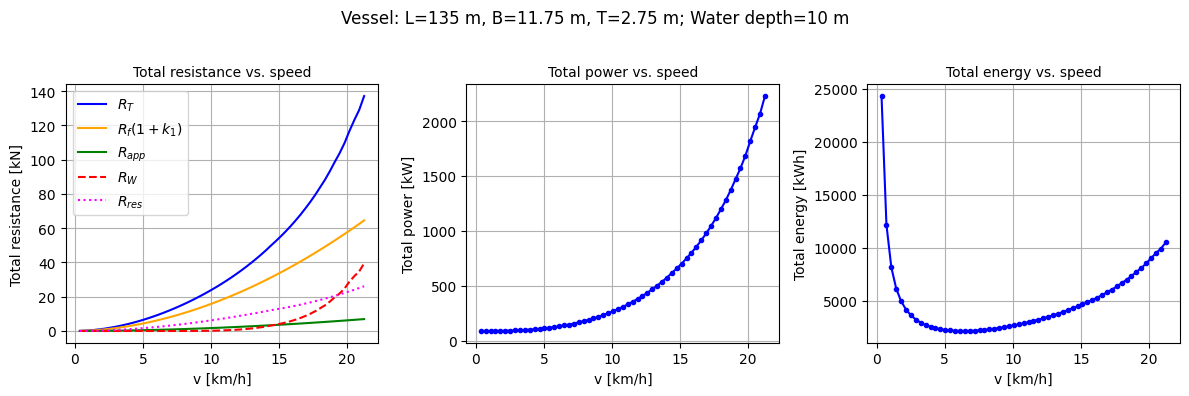

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot resistance components
axes[0].plot(results_df['v'] * 3.6, results_df['R_tot'], '-', c='blue', label='$R_T$')
axes[0].plot(results_df['v'] * 3.6, results_df['R_f_one_k1'], '-', c='orange', label='$R_f (1+k_1)$')
axes[0].plot(results_df['v'] * 3.6, results_df['R_APP'], '-', c='green', label='$R_{app}$')
axes[0].plot(results_df['v'] * 3.6, results_df['R_W'], '--', c='red', label='$R_W$')
axes[0].plot(results_df['v'] * 3.6, results_df['R_res'], ':', c='magenta', label='$R_{res}$')
axes[0].set_xlabel('v [km/h]')
axes[0].set_ylabel('Total resistance [kN]')
axes[0].set_title('Total resistance vs. speed', fontsize=10)
axes[0].legend(loc='upper left')
axes[0].grid(True)

# Plot total power
axes[1].plot(results_df['v'] * 3.6, results_df['P_tot'], '-o', c='blue', markersize=3)
axes[1].set_xlabel('v [km/h]')
axes[1].set_ylabel('Total power [kW]')
axes[1].set_title('Total power vs. speed', fontsize=10)
axes[1].grid(True)

# Plot total energy
axes[2].plot(results_df['v'] * 3.6, results_df['total_energy'], '-o', c='blue', markersize=3)
axes[2].set_xlabel('v [km/h]')
axes[2].set_ylabel('Total energy [kWh]')
axes[2].set_title('Total energy vs. speed', fontsize=10)
axes[2].grid(True)

fig.suptitle(f"Vessel: L={vessel_params['L']} m, B={vessel_params['B']} m, T={vessel_params['T']} m; Water depth={water_depth_m} m", fontsize=12)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Panel 1 in the figure above corresponds to Part IV - Figure 5.4 in Van Koningsveld et al (2023), https://doi.org/10.5074/T.2021.004. Panel 2 shows how the R_tot from Panel 1 is converted to P_tot, multiplying with v and using various efficiency factors. Panel 3 shows the total energy that is required to pass the 100 km long edge. This total energy is derived by multiplying the P_tot with the time it takes to pass the edge. For very low v's the R_tot is low, but it also takes long to pass the edge. For high v's the R_tot escalates, but the time to pass the edge reduces.